



Nous avons décidé de développer un programme de modèle de machine learning permettant de procéder à une tache de reconnaisance d'émotion sur la base d'enrigistrments audio.
Cet exercice s'inscrit dans le cadre de notre projet de traitement de signal, et l'application; du chargement des audios jusqu'à la mise en oeuvre d'un modèle de machine learning remet les l'usage des fonctionnement des signaux audio pour la transformation de son en données numérique. 
La mise en place de deep leanring met en oeuvre une suyite de transmission de flux de fréquence d'une couche en une autre pour permettre à notre modèle  de deep learning la reconnaissances des émotions.



liens Ressources kaagle: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data

Le micro = un thermomètre très rapide
Comme un thermomètre qui prend la température très souvent, le micro “prend la pression sonore” 16 000 fois par seconde.
→ On obtient une liste de nombres (l’onde). C’est déjà du numérique.

On lit la vidéo du son image par image
Un son change tout le temps. On le découpe en petites tranches de ~25 ms qui se chevauchent (tous les 10 ms), comme si on regardait une vidéo image par image.
→ Chaque tranche = une fenêtre.

Un prisme pour le son
Sur chaque fenêtre, on utilise un “prisme” (la FFT/STFT) qui décompose le son en couleurs musicales (les fréquences).
→ En répétant pour toutes les fenêtres, on obtient une carte Temps × Fréquences : le spectrogramme.
Pense : lignes = graves → aigus ; colonnes = le temps qui passe ; couleur = énergie.

On parle le langage de l’oreille : l’échelle Mel
L’oreille distingue mieux les basses que les très aigus. On regroupe donc les fréquences en bandes Mel (plus de détails en bas, moins en haut).
→ Ça donne une image plus compacte et plus “humaine”.

Le “truc du log” (dB) — comme un bouton de volume intelligent
Dans un son, certaines parties sont très fortes, d’autres très faibles. Si on laissait tout tel quel, l’image aurait des zones cramées et d’autres invisibles.
Le logarithme (dB), c’est comme un bouton de volume automatique :

il compresse ce qui est trop fort,

il remonte ce qui est trop faible.
Résultat : on voit tout clairement dans la même image (le log-Mel spectrogramme).
(Analogie photo : le “log”, c’est comme le mode HDR qui évite ciel tout blanc et ombres noires).

Option résumé express : les MFCC
Plutôt que garder toute l’image, on peut en faire un résumé en quelques nombres (les MFCC).
C’est comme résumer un paysage par sa forme générale : ça tient sur un petit vecteur pratique pour certains modèles.

Le label (émotion) vient du nom du fichier
Pour RAVDESS, l’émotion est codée dans le 3ᵉ nombre du nom (ex. …-05-… = angry).
→ On associe l’image (ou le vecteur) à ce label pour entraîner le modèle.

# 1 Import des modules - Paramètres globaux


In [3]:
# ===== IMPORTS =====
import os
import re
import numpy as np
import pandas as pd
import librosa

# ===== PARAMÈTRES GLOBAUX =====
project_audio_root = "audio_speech_actors_01-24"  # dossier RAVDESS (speech) téléchargé

target_sample_rate_hz = 16000          # tout charger à 16 kHz
fft_window_size_samples = 400          # ~25 ms à 16 kHz
hop_length_samples = 160               # ~10 ms à 16 kHz
num_mfcc_coefficients = 20             # nb de MFCC de base (avant deltas)
fixed_duration_seconds = 3.0           # on tronque/pad à 3 s pour homogénéiser

# mapping code -> label d'émotion (3e champ du nom de fichier)
emotion_code_to_label = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

# regex pour extraire les métadonnées du nom de fichier RAVDESS
# schéma : MM-VC-EE-II-SS-RR-OO.wav
ravdess_filename_pattern = re.compile(
    r"(?P<modality>\d{2})-(?P<vocal_channel>\d{2})-(?P<emotion_code>\d{2})-"
    r"(?P<intensity>\d{2})-(?P<statement>\d{2})-(?P<repetition>\d{2})-(?P<actor_id>\d{2})\.(?:wav|mp3|mp4)$"
)


# Fonctions Utiles


## Etapes 1 : Lecture fichier audio - Onde - Numérique

Le micro capte la pression de l’air et la carte son la mesure très vite (ex. 16 000 fois par seconde). Chaque mesure est un nombre → on obtient une suite 
𝑥
[
𝑛
]
x[n] d’amplitudes stockées dans le fichier audio (WAV). C’est déjà des données numériques.





In [4]:
def load_mono_audio_with_fixed_duration(file_path: str) -> np.ndarray:
    """
    Charge un fichier audio en mono à 'target_sample_rate_hz'
    et renvoie exactement 'fixed_duration_seconds' via padding/troncature.
    """
    waveform, _ = librosa.load(file_path, sr=target_sample_rate_hz, mono=True)
    target_num_samples = int(fixed_duration_seconds * target_sample_rate_hz)
    if len(waveform) < target_num_samples:
        waveform = np.pad(waveform, (0, target_num_samples - len(waveform)))
    else:
        waveform = waveform[:target_num_samples]
    return waveform


## Etape 2: Extraction du label depuis le nom de fichier


In [5]:
def parse_ravdess_metadata_from_filename(file_name: str):
    """
    Extrait les métadonnées RAVDESS depuis le nom du fichier.
    Retourne un dict avec 'emotion_label' et 'actor_id', ou None si non reconnu.
    """
    match = ravdess_filename_pattern.match(os.path.basename(file_name))
    if not match:
        return None
    groups = match.groupdict()
    return {
        "emotion_label": emotion_code_to_label[groups["emotion_code"]],
        "actor_id": int(groups["actor_id"]),
        "vocal_channel_code": groups["vocal_channel"],  # '01' = speech, '02' = song
        "modality_code": groups["modality"],            # '03' = audio-only
    }


## Etape 3 : Transformation audio → vecteur numérique (MFCC + deltas + résumé)

In [6]:
def compute_mfcc_feature_vector(waveform: np.ndarray) -> np.ndarray:
    """
    Calcule MFCC + deltas + delta-deltas, puis fait un résumé temporel
    (moyenne et écart-type par coefficient) pour obtenir un vecteur fixe.
    Taille par défaut : 2 * (3 * num_mfcc_coefficients) = 120.
    """
    mfcc_base = librosa.feature.mfcc(
        y=waveform,
        sr=target_sample_rate_hz,
        n_mfcc=num_mfcc_coefficients,
        n_fft=fft_window_size_samples,
        hop_length=hop_length_samples,
    )
    mfcc_delta = librosa.feature.delta(mfcc_base)
    mfcc_delta2 = librosa.feature.delta(mfcc_base, order=2)

    mfcc_stack = np.vstack([mfcc_base, mfcc_delta, mfcc_delta2])  # [3*C, T]
    mean_over_time = mfcc_stack.mean(axis=1)
    std_over_time = mfcc_stack.std(axis=1)

    feature_vector = np.hstack([mean_over_time, std_over_time]).astype(np.float32)
    return feature_vector


# Etape 4: Scan du dossier - Transformation - Construction du data frame

In [7]:
records = []

for current_root, _, file_names in os.walk(project_audio_root):
    for file_name in file_names:
        if not file_name.lower().endswith((".wav", ".mp3", ".mp4")):
            continue

        file_path = os.path.join(current_root, file_name)

        metadata = parse_ravdess_metadata_from_filename(file_path)
        if metadata is None:
            continue  # ignorer les fichiers qui ne suivent pas la convention

        waveform = load_mono_audio_with_fixed_duration(file_path)
        feature_vector = compute_mfcc_feature_vector(waveform)

        records.append({
            "file_path": file_path,                       # chemin complet
            "actor_id": metadata["actor_id"],            # identifiant d'acteur (1..24)
            "emotion_label": metadata["emotion_label"],  # étiquette d'émotion
            "feature_vector": feature_vector             # vecteur numpy (dimension 120)
        })

audio_features_df = (
    pd.DataFrame(records)
      .sort_values(["actor_id", "file_path"])
      .reset_index(drop=True)
)

print(audio_features_df.head())
print(
    "Nombre d'échantillons:", len(audio_features_df),
    "| Dimension du vecteur de caractéristiques:",
    audio_features_df.iloc[0]["feature_vector"].shape[0] if len(audio_features_df) else None
)


                                           file_path  actor_id emotion_label  \
0  audio_speech_actors_01-24\Actor_01\03-01-01-01...         1       neutral   
1  audio_speech_actors_01-24\Actor_01\03-01-01-01...         1       neutral   
2  audio_speech_actors_01-24\Actor_01\03-01-01-01...         1       neutral   
3  audio_speech_actors_01-24\Actor_01\03-01-01-01...         1       neutral   
4  audio_speech_actors_01-24\Actor_01\03-01-02-01...         1          calm   

                                      feature_vector  
0  [-841.4503, 59.81522, 4.9465384, 19.119576, 7....  
1  [-829.9087, 59.93275, 4.2243505, 23.23264, 6.5...  
2  [-840.1337, 61.38956, 5.649216, 19.203583, 5.2...  
3  [-840.86554, 59.105793, 7.6038814, 18.920372, ...  
4  [-857.76434, 71.3634, 8.038914, 21.934023, 8.0...  
Nombre d'échantillons: 1440 | Dimension du vecteur de caractéristiques: 120


# Représentation visuelle 

Fichier choisi: audio_speech_actors_01-24\Actor_02\03-01-01-01-01-01-02.wav


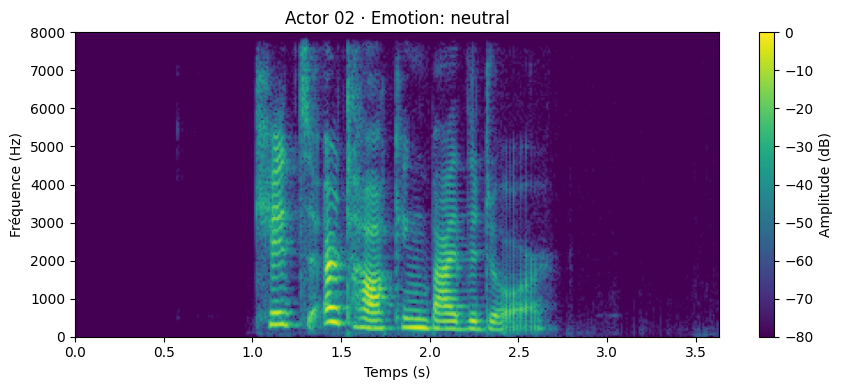

In [8]:
# --- Dépendances pour l'affichage (aucune fonction réécrite) ---
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# --- Saisie utilisateur ---
actor_id_str = input("Numéro d'acteur (1..24) : ").strip()
emotion_label_input = input(
    "Émotion (neutral, calm, happy, sad, angry, fearful, disgust, surprised) : "
).strip().lower()

# --- Vérifications simples ---
actor_id = int(actor_id_str)
if not (1 <= actor_id <= 24):
    raise ValueError("actor_id doit être entre 1 et 24.")

# Inversion du mapping existant (sans le redéfinir) -> label -> code
label_to_code = {v: k for k, v in emotion_code_to_label.items()}
if emotion_label_input not in label_to_code:
    raise ValueError(
        f"Émotion inconnue: '{emotion_label_input}'. "
        f"Choisis parmi: {list(label_to_code.keys())}"
    )
target_emotion_code = label_to_code[emotion_label_input]

# --- Recherche d'un fichier correspondant (VC=01 speech, MM=03 audio-only) ---
actor_dir = os.path.join(project_audio_root, f"Actor_{actor_id:02d}")
if not os.path.isdir(actor_dir):
    raise FileNotFoundError(f"Dossier introuvable: {actor_dir}")

selected_path = None
for fname in sorted(os.listdir(actor_dir)):
    m = ravdess_filename_pattern.match(fname)
    if not m:
        continue
    g = m.groupdict()
    if g["vocal_channel"] != "01":   # 01 = parole
        continue
    if g["modality"] != "03":        # 03 = audio-only
        continue
    if g["emotion_code"] != target_emotion_code:
        continue
    selected_path = os.path.join(actor_dir, fname)
    break

if selected_path is None:
    raise FileNotFoundError(
        f"Aucun fichier trouvé pour actor={actor_id} & emotion={emotion_label_input}."
    )

print("Fichier choisi:", selected_path)

# --- Chargement audio (onde numérique) ---
y, sr = librosa.load(selected_path, sr=target_sample_rate_hz, mono=True)

# --- STFT -> Spectrogramme en dB (fréquence x temps) ---
stft_complex = librosa.stft(
    y=y,
    n_fft=fft_window_size_samples,
    hop_length=hop_length_samples,
    window="hann",
    center=True
)
magnitude = np.abs(stft_complex)
power = magnitude ** 2
S_db = librosa.power_to_db(power, ref=np.max)

# --- Axes fréquence/temps pour l'affichage ---
freqs_hz = librosa.fft_frequencies(sr=sr, n_fft=fft_window_size_samples)
times_s  = librosa.frames_to_time(
    np.arange(S_db.shape[1]),
    sr=sr,
    hop_length=hop_length_samples
)

# --- Affichage du spectrogramme ---
plt.figure(figsize=(9, 4))
extent = [
    times_s[0],
    times_s[-1] if len(times_s) > 1 else 0.0,
    freqs_hz[0],
    freqs_hz[-1],
]
plt.imshow(S_db, origin="lower", aspect="auto", extent=extent)
plt.colorbar(label="Amplitude (dB)")
plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(f"Actor {actor_id:02d} · Emotion: {emotion_label_input}")
plt.tight_layout()
plt.show()


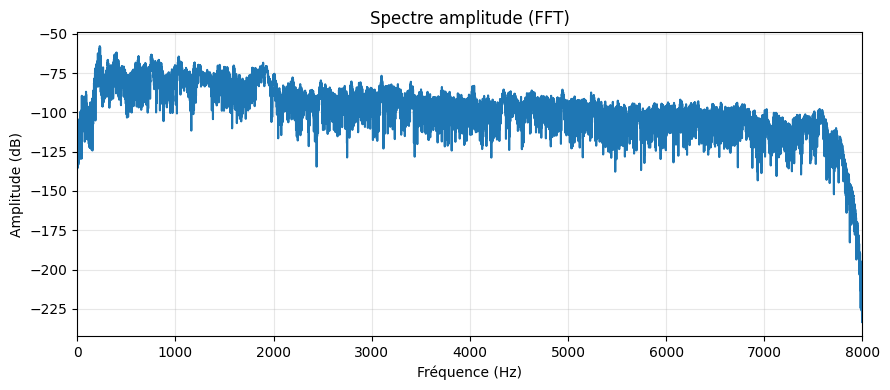

In [11]:
# === 1) Spectre amplitude (FFT "one-shot") ===
# - fenêtre Hann pour limiter les fuites
# - FFT réelle (partie positive seulement)
# - échelle dB
import numpy as np
import matplotlib.pyplot as plt

n_fft_global = 1 << (len(y) - 1).bit_length()  # zéro-padding à la puissance de 2 (rapide, optionnel)
window = np.hanning(len(y))
Y = np.fft.rfft(y * window, n=n_fft_global)
freq_axis = np.fft.rfftfreq(n_fft_global, d=1.0/sr)

amp = np.abs(Y) / (window.sum()/2)  # normalisation approx. pour la fenêtre
amp_db = 20 * np.log10(np.maximum(amp, 1e-12))

plt.figure(figsize=(9, 4))
plt.plot(freq_axis, amp_db)
plt.xlim(0, sr/2)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.title("Spectre amplitude (FFT)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Construction de la base de données pour l'entrainement 

In [9]:


# audio_features_df doit déjà exister avec:
# ['file_path', 'actor_id', 'emotion_label', 'feature_vector']

# 1) Empiler les vecteurs de features en matrice [N, D]
X = np.stack(audio_features_df["feature_vector"].to_list()).astype(np.float32)

# 2) Construire un DF avec une colonne par dimension de feature
feature_cols = [f"f_{i}" for i in range(X.shape[1])]
features_df = pd.DataFrame(X, columns=feature_cols)

# 3) Ajouter les colonnes utiles au ML
df_for_ml = pd.concat(
    [features_df,
     audio_features_df[["emotion_label", "actor_id"]].reset_index(drop=True)],
    axis=1
)

#ption: si tu veux seulement (features, label) sans actor_id:
df_for_ml = pd.concat([features_df, audio_features_df["emotion_label"].reset_index(drop=True)], axis=1)

# print(df_for_ml.head(), "\nShape:", df_for_ml.shape)
df_for_ml["emotion_label"].value_counts()



emotion_label
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64

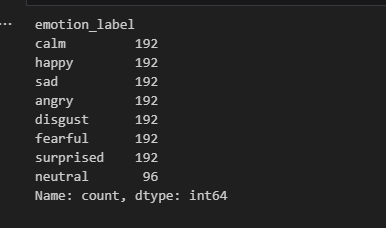

In [10]:
# Sauvegarde à la racine du projet
df_for_ml.to_csv("./df_for_ml.csv", index=False)